In [1]:
import numpy as np
import pandas as pd
import hotspot
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns

import scipy as sp

from scipy.io import mmread
from scipy.sparse import csr_matrix

from ete3 import Tree
import networkx as nx
from tqdm import tqdm

import cassiopeia.TreeSolver.utilities as util
from cassiopeia.TreeSolver.Node import Node


In [514]:
counts_raw = mmread("../JQ19/5k/RNA/ALL_Samples/GRCh38/matrix.mtx")
counts_raw = csr_matrix(counts_raw)
barcodes = pd.read_table("../JQ19/5k/RNA/ALL_Samples/GRCh38/barcodes.tsv", header=None)[0].values
genes = pd.read_table("../JQ19/5k/RNA/ALL_Samples/GRCh38/genes.tsv", header=None)[1]
meta = pd.read_csv("../JQ19/5k/RNA/LG_meta_fixed.txt", sep='\t', index_col = 0)

In [518]:
tree = Tree("../JQ19/5k/trees/lg7/lg7_tree_hybrid_priors.alleleThresh.processed.txt", format=1)
leaves = tree.get_leaf_names()

print(len(leaves))

# only look at RE
# leaves = [n for n in leaves if 'RE' in n]

print(len(leaves))

keep_barcodes = np.intersect1d(barcodes, leaves)

tree.prune(keep_barcodes)

663
663


In [519]:
is_valid = [x in keep_barcodes for x in barcodes]
is_valid_indices = np.nonzero(is_valid)[0]
valid_barcodes = [barcodes[i] for i in is_valid_indices]

norm_fact = np.median(np.asarray(counts_raw.sum(axis=0)))

counts = counts_raw[:, is_valid_indices].todense()
counts = pd.DataFrame(counts, index=genes, columns=valid_barcodes)

# Subset for only genes detected in at least 10% of cells
counts = counts.loc[
    (counts > 0).sum(axis=1) >= 0.1*counts.shape[1]
]

print(counts.shape)

(6025, 603)


In [501]:
hs = hotspot.Hotspot(counts, model='danb', tree=tree)

K = int(np.sqrt(counts.shape[1]))
print('fitting Hotspot model with ' + str(K) + " neighbors")
hs.create_knn_graph(
    weighted_graph=False, n_neighbors=40,
)

 10%|▉         | 42/437 [00:00<00:00, 419.65it/s]

fitting Hotspot model with 20 neighbors


100%|██████████| 437/437 [00:01<00:00, 407.88it/s]


In [502]:
hs_results = hs.compute_autocorrelations(jobs=2)

hs_results.sort_values(by='Z',ascending=False)

100%|██████████| 6101/6101 [00:01<00:00, 4589.39it/s]


In [503]:
hs_genes = hs_results.index[hs_results.FDR < 0.1]

# Compute pair-wise local correlations between these genes
lcz = hs.compute_local_correlations(hs_genes, jobs=2)

100%|██████████| 498/498 [00:00<00:00, 14975.90it/s]


Computing pair-wise local correlation on 498 features...


100%|██████████| 123753/123753 [00:12<00:00, 10138.88it/s]


In [504]:
modules = hs.create_modules(
        min_gene_threshold=120, core_only=True, fdr_threshold=1.0,
)

In [212]:
## function copied from the original Hotspot codebase, to add the option for annotating a subset of genes

from scipy.cluster.hierarchy import leaves_list

def local_correlation_plot(
            local_correlation_z, modules, linkage,
            mod_cmap='tab10', vmin=-8, vmax=8,
            z_cmap='RdBu_r', yticklabels=False, gene_subset=[]
):

    row_colors = None
    colors = list(plt.get_cmap(mod_cmap).colors)
    module_colors = {i: colors[(i-1) % len(colors)] for i in modules.unique()}
    module_colors[-1] = '#ffffff'

    row_colors1 = pd.Series(
        [module_colors[i] for i in modules],
        index=local_correlation_z.index,
    )

    row_colors = pd.DataFrame({
        "Modules": row_colors1,
    })

    cm = sns.clustermap(
        local_correlation_z,
        row_linkage=linkage,
        col_linkage=linkage,
        vmin=vmin,
        vmax=vmax,
        cmap=z_cmap,
        xticklabels=False,
        yticklabels=yticklabels,
        row_colors=row_colors,
        rasterized=True,
    )

    fig = plt.gcf()
    plt.sca(cm.ax_heatmap)
    plt.ylabel("")
    plt.xlabel("")

    cm.ax_row_dendrogram.remove()

    # Add 'module X' annotations
    ii = leaves_list(linkage)

    mod_reordered = modules.iloc[ii]

    mod_map = {}
    y = np.arange(modules.size)

    for x in mod_reordered.unique():
        if x == -1:
            continue

        mod_map[x] = y[mod_reordered == x].mean()

    plt.sca(cm.ax_row_colors)
    for mod, mod_y in mod_map.items():
        plt.text(-.5, y=mod_y, s="Module {}".format(mod),
                 horizontalalignment='right',
                 verticalalignment='center')
    plt.xticks([])

    # Find the colorbar 'child' and modify
    min_delta = 1e99
    min_aa = None
    for aa in fig.get_children():
        try:
            bbox = aa.get_position()
            delta = (0-bbox.xmin)**2 + (1-bbox.ymax)**2
            if delta < min_delta:
                delta = min_delta
                min_aa = aa
        except AttributeError:
            pass

    min_aa.set_ylabel('Z-Scores')
    min_aa.yaxis.set_label_position("left")
    
    # cm.ax_heatmap.set_yticklabels(cm.ax_heatmap.get_ymajorticklabels(), font=0.1)

    y_labels_ticks = cm.ax_heatmap.get_yticklabels()

    total_genes_above_threshold = 0
    for i, ytickdata in enumerate(y_labels_ticks):
        gene = ytickdata._text
        if gene in gene_subset:
            total_genes_above_threshold = total_genes_above_threshold + 1
        else:
            ytickdata._text = ''

    print("total_genes_above_threshold {}".format(total_genes_above_threshold))

    # re set the tick labels with the modified list
    cm.ax_heatmap.set_yticklabels(y_labels_ticks, fontsize = 2)

In [49]:
results = hs.results.join(hs.modules)

gene_subset = results.loc[results.Module == 1].sort_values(by = 'Z', ascending=False).index.values[:10]
gene_subset = np.concatenate((gene_subset, results.loc[results.Module == 2].sort_values(by = 'Z', ascending=False).index.values[:10]))

print(gene_subset)

['MUC5AC' 'TFF1' 'CEACAM6' 'C19orf33' 'TFF3' 'JUND' 'TMEM141' 'MUC5B'
 'FOSB' 'LYZ' 'KRT17' 'RPS6' 'LDHB' 'RPL3' 'MT-CYB' 'ATP5G1' 'HMGN3'
 'POLR2L' 'CHCHD2' 'HNRNPA1']


total_genes_above_threshold 20


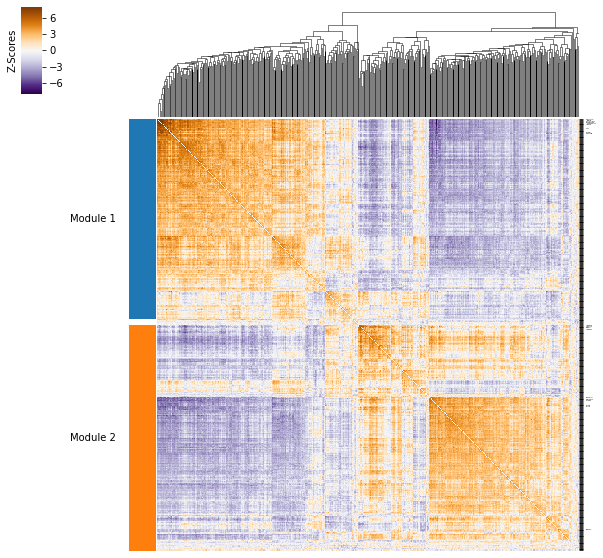

In [509]:
results = hs.results.join(hs.modules)

gene_subset = results.loc[results.Module == 1].sort_values(by = 'Z', ascending=False).index.values[:10]
gene_subset = np.concatenate((gene_subset, results.loc[results.Module == 2].sort_values(by = 'Z', ascending=False).index.values[:10]))

# comment out if you'd like to annotate a subset
# gene_subset = []

# if you'd like to annotate a subset of genes, set yticklabels=True
g = local_correlation_plot(
                    hs.local_correlation_z, hs.modules, hs.linkage,
                    mod_cmap='tab10', vmin=-8, vmax=8,
                    z_cmap="PuOr_r", yticklabels=True, gene_subset = gene_subset)
plt.savefig("lg7_module_heatmap.REcontrol.eps")

In [510]:
module_scores = hs.calculate_module_scores()



 50%|█████     | 1/2 [00:00<00:00,  8.93it/s]

Computing scores for 2 modules...


100%|██████████| 2/2 [00:00<00:00,  7.65it/s]


In [512]:
module = 2
for mod in module_scores.columns:
    results = hs.results.join(hs.modules)
    results = results.loc[results.Module == int(mod)]
    print(results.shape)
    results.to_csv("lg7_mod" + str(mod) +".RE.txt", sep='\t')

results = hs.results.join(hs.modules)
results = results.loc[results.Module == module]
results.sort_values('Z', ascending=False).head(20)

(231, 5)
(260, 5)


,C,Z,Pval,FDR,Module
Gene,,,,,
KRT17,0.073959,22.390832,2.417400e-111,1.843569e-108,2.0
RPS6,0.159752,22.024270,8.430295e-108,5.714804e-105,2.0
IGFBP4,0.061196,10.432875,8.774820e-26,1.982784e-23,2.0
DKK1,0.084990,10.396916,1.280442e-25,2.789992e-23,2.0
IGFBP7,0.077705,9.986826,8.703334e-24,1.659345e-21,2.0
POLR2L,0.072647,8.880737,3.320935e-19,5.065257e-17,2.0
RPL3,0.088613,8.610433,3.639241e-18,5.415368e-16,2.0
HMGN3,0.093183,8.594386,4.185542e-18,6.079999e-16,2.0
ANXA4,0.052980,8.573833,5.004848e-18,7.101065e-16,2.0


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


1


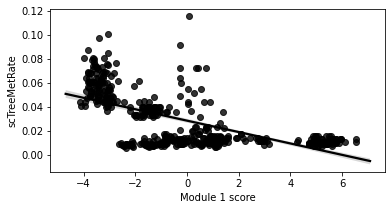

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


(-0.6361549142293923, 6.075560876404264e-51)
2


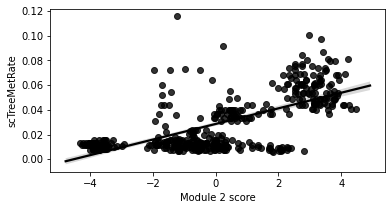

(0.6762139554322475, 1.0567890942383614e-59)


In [515]:
import seaborn as sns
import scipy.stats as scs
meta_sub = meta.loc[keep_barcodes]

for module in module_scores.columns:
    print(module)
    h = plt.figure(figsize = (6, 3))
    ax = sns.regplot(module_scores.loc[meta_sub.index.values, module], meta_sub['scTreeMetRate'], color = 'black')
    plt.xlabel("Module " + str(module) + " score")
    plt.ylabel("scTreeMetRate")
    plt.savefig('lg7_mod' + str(module) + '.RE.eps')
    plt.show()
    
    print(scs.pearsonr(module_scores.loc[meta_sub.index.values, module], meta_sub['scTreeMetRate']))

296 184


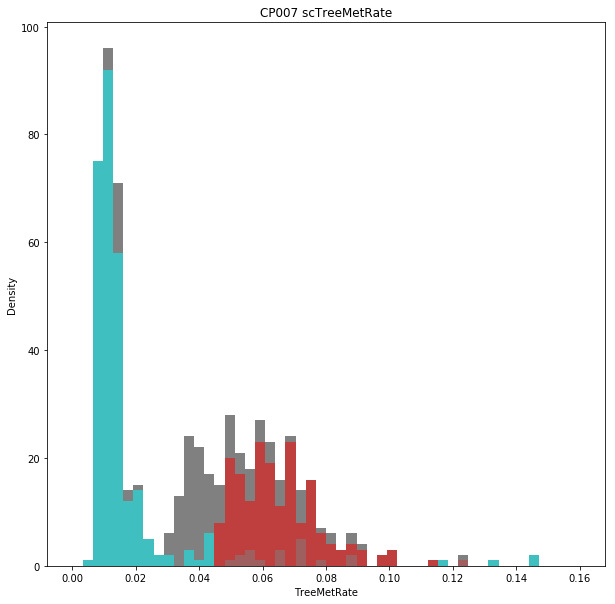

In [25]:
cell1 = 'M2.TGGTTCCGTCCTCTTG-1'
cell2 = 'RE.AGTTGGTAGAGGACGG-1'

lowmet_cell = "RE.GATCGATGTGATAAGT-1"
# find split 1 and 2
split1 = []
split2 = []
for c in tree.children:
    leaves = c.get_leaf_names()
    if lowmet_cell in leaves:
        split1 = leaves


parent = tree        
while not parent.is_leaf():
    found = False
    for c in parent.children:
        leaves = c.get_leaf_names()
        if cell1 in leaves:

            if cell2 not in leaves:
                split2 = leaves
                found = True

            parent = c

    if found:
        break
            

print(len(split1), len(split2))

h = plt.figure(figsize = (10,10))
plt.hist(meta_sub['scTreeMetRate'], bins = 50, color='gray', range = (0, 0.16))
plt.hist(meta_sub.loc[split1, 'scTreeMetRate'], bins=50, color='cyan', alpha = .5, range = (0, 0.16))
plt.hist(meta_sub.loc[split2, 'scTreeMetRate'], bins=50, color='red', alpha = .5, range = (0, 0.16))
plt.xlabel('TreeMetRate')
plt.ylabel('Density')
plt.title("CP007 scTreeMetRate")
plt.savefig('lg7_treemetrate.eps')
plt.show()

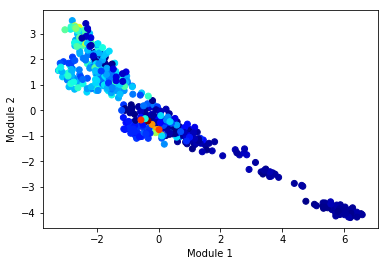

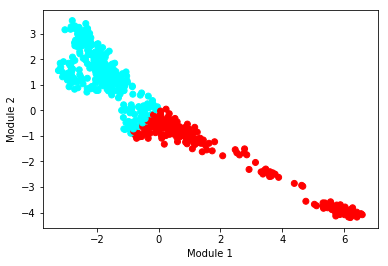

In [1005]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

dz = meta_sub.loc[module_scores.index.values, 'DynamicMetScore']
dz.values
norm = plt.Normalize()
colors = plt.cm.jet(norm(dz.values))

_class = module_scores.columns[module_scores.apply(lambda x: np.argmax(x.values), axis=1)].values

x = module_scores[[1]]
y = module_scores[[2]]
plt.scatter(x, y, color=colors)
plt.xlabel('Module 1')
plt.ylabel('Module 2')
plt.show()

colors2 = ['cyan' if c == 2 else 'red' for c in _class]

plt.scatter(x, y, color=colors2)
plt.xlabel('Module 1')
plt.ylabel('Module 2')

module_assign['Class'] = _class
module_assign['ClassColor']  = colors2

# module_assign.to_csv("lg7_hotspot_modulescores.2.txt", sep='\t')

In [442]:
from umap import UMAP
from sklearn.decomposition import PCA

counts_z = counts \
    .subtract(counts.mean(axis=1), axis=0) \
    .divide(counts.std(axis=1), axis=0)

pca_data = PCA(n_components=20).fit_transform(counts_z.values.T)
umap_data = UMAP(n_neighbors=K, min_dist=0.5).fit_transform(pca_data)
umap_data = pd.DataFrame(umap_data, index=counts.columns, columns=['UMAP1', 'UMAP2'])

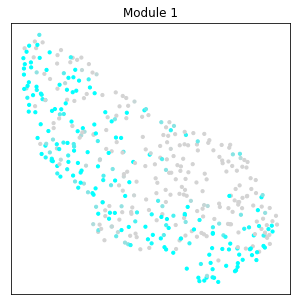

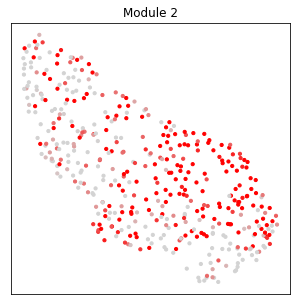

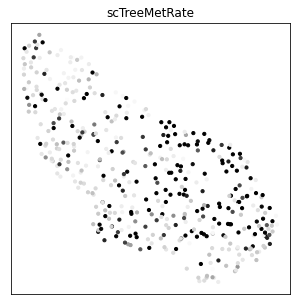

In [521]:
norm=plt.Normalize(-1,1)
cmap1 = matplotlib.colors.LinearSegmentedColormap.from_list("", ["lightgrey", "red"])
cmap2 = matplotlib.colors.LinearSegmentedColormap.from_list("", ["lightgrey", "cyan"])

h = plt.figure(figsize = (5,5))
sc = plt.scatter(umap_data.UMAP1, umap_data.UMAP2, s=10, c=hs.module_scores[1], vmin = -1, vmax=1, cmap=cmap2, norm=norm)
plt.xticks([])
plt.yticks([])
plt.title("Module 1")
# plt.savefig("lg7_mod1_umap.RE.eps")

plt.show()

h = plt.figure(figsize = (5,5))
sc = plt.scatter(umap_data.UMAP1, umap_data.UMAP2, s=10, c=hs.module_scores[2], vmin = -1, vmax=1, cmap=cmap1, norm=norm)
plt.xticks([])
plt.yticks([])
plt.title("Module 2")
# plt.savefig("lg7_mod2_umap.RE.eps")
plt.show()


h = plt.figure(figsize = (5,5))
dz = meta_sub.loc[module_scores.index.values, 'scTreeMetRate']
cmap3 = matplotlib.colors.LinearSegmentedColormap.from_list("", ["white", "black"])
sc = plt.scatter(umap_data.UMAP1, umap_data.UMAP2,
        s=10, c=dz, cmap = cmap3, vmax = np.percentile(dz, 75))
plt.title("scTreeMetRate")
plt.xticks([])
plt.yticks([])
# plt.savefig("lg7_metrate_umap.RE.eps")
plt.show()

# _class = module_scores.columns[module_scores.apply(lambda x: np.argmax(x.values), axis=1)].values
# print(_class[:10])
# colors2 = ['cyan' if c == 1 else 'red' for c in _class]
# print(colors2[:10])
# sc = plt.scatter(umap_data.UMAP1, umap_data.UMAP2,
#         s=10, color=colors2,
#         rasterized=True)
